In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Problem statement: Leveraging the dataset located here: https://www.eia.gov/consumption/residential/data/2009/index.php?view=microdata, can you build a model that predicts consumption? The electric consumption is located in the KWH field

# Assumptions:
* I went through all the variables provided in <b>public_layout.csv</b> and with the help of information provided in <b>recs2009_public_codebook.xlsx</b> marked each and every variable as:
    * Numerical -> Continuous or Discrete
    * Categorical -> Binary, Nominal or Ordinal
    * This information is captured in <b>public_layout_marked.csv</b>
* Only the variables associated with Electricity consumption are to be used. As a result I <b>exclude</b> a certain set of variables from analysis. Some reasons for exclusion are:
    * Talk about non-electricity related consumption (like Kerosene, wood etc)
    * Talk about electricity but in different unit (Btu). This will be highly correlated with KWH based measurements.
    * Family information like profession, age of members etc.
    * Variables describing measurements for secondary, tertiary devices and structures e.g. second most used TV, second most used refrigerator etc.
    * Variables that talk about whether or not assistance was taken to replace Ac, Heating etc. 
    * Variables that are extremely skewed e.g. ELOTHER, USEEL
    * All these variables can be found in file <b>exclude_var.json<b>
* Get rid of all imputation variables (starting with Z)
* Some Nominal variables asking for type of fuel used are redefined to ask whether or not electricity is used (i.e. Yes/ No/ NA) e.g. STOVENFUEL -> STOVENFUEL_elec
    * The list of such variables is in <b>nominal_var_break_elec.json</b>    

# Summary of steps to follow:
1. Perform Exploratory Data Analysis based on the given dataset. This involved graphing different types of variables & trying to look for patterns. It includes by not limited to:
    * Check missing values
    * Distribution of output variable (KWH): Normal? Range of values? Any outliers?
    * Plot different input/ independent variables. The type of plotting method depends on type of variable.
        * Numerical_Continuous: Probability density graphs.
        * Numerical_Discrete: Count Plots.
        * Categorical_Binary, Categorical_Ordinal, Categorical_Nominal: Boxplot with respect to output variable (KWH or KWH_normal).
    * Perform tests (2 sample T test for Categorical_Binary) and (ANOVA F Test for Categorical_Ordinal and Categorical_Nominal) to see whether the difference between means of groups are significant. These tests help to narrow down the list of  categorical variables to use (<b>categorical_var_chosen.txt</b>)
    * Variable Selection:
        * Understand the Correlation between Independent variables and Output Variable
        * Understand correlation between Independent Variables to identify Multicollinearity
2. Model training
    * Prepare data for the model: Encode the categorical variables using OneHotEncoding or OrdinalEncoding as per requirement
    * Split the data into training and test sets.
    * Get a baseline performance on test data (TODO)
    * Choose Loss function (MAE/ MSE etc)
    * Choose metric to evaluate the model performace (MAPE etc.)
    * Train the RandomForestRegressor model
    * Report performance of model on test set and report it. 
    * Prvide feature importance (intrinsic to RandomForestRegressor model)

In [2]:
## Import all the desired libraries.
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
import numpy as np
import json
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

# File Names and path

In [3]:
data_path = "/home/hsahi/HardikSahi/JupNotebook3.6/Data"

## See Assumptions section to understand what the following files contain.
data_file_name = "recs2009_public.csv"
public_layout_file_name = "public_layout_marked.csv"
public_codebook_file_name = "recs2009_public_codebook.xlsx"
exclude_variable_json_file_name = "exclude_var.json"
nominal_var_break_elec_json_file_name = r'nominal_var_break_elec.json'
categorical_var_chosen_file_name = "categorical_var_chosen.txt"

In [4]:
data_df = pd.read_csv(Path(data_path)/data_file_name)
public_layout_df = pd.read_csv(Path(data_path)/public_layout_file_name)
with open(data_path+'/'+exclude_variable_json_file_name, 'r') as r:
    exclude_variable_json = json.loads(r.read())

with open(data_path+'/'+nominal_var_break_elec_json_file_name, 'r') as r:
    nominal_var_break_elec_json = json.loads(r.read())
#nominal_var_break_elec_json = json.loads(open(Path(data_path)/nominal_var_break_elec_json_file_name).read())

In [6]:
## Drop ID column
data_df = data_df.drop(['DOEID'], axis=1)

In [7]:
## Check the size of df ==> (12083, 939)
print(data_df.shape) 

(12083, 939)


# Get the list of Numerical and Catgorical INDEPENDENT variables as I have marked in public_layout_df

In [8]:
categorical_binary_variable_list = public_layout_df[(public_layout_df["Variable_Type_ML"]=="Categorical") & (public_layout_df["Variable_SubType_ML"]=="Binary")]["Variable Name"].values.tolist() ## 89
categorical_nominal_variable_list = public_layout_df[(public_layout_df["Variable_Type_ML"]=="Categorical") & (public_layout_df["Variable_SubType_ML"]=="Nominal")]["Variable Name"].values.tolist() ## 234
categorical_ordinal_variable_list = public_layout_df[(public_layout_df["Variable_Type_ML"]=="Categorical") & (public_layout_df["Variable_SubType_ML"]=="Ordinal")]["Variable Name"].values.tolist() ## 107

numerical_discrete_variable_list = public_layout_df[(public_layout_df["Variable_Type_ML"]=="Numerical") & (public_layout_df["Variable_SubType_ML"]=="Discrete")]["Variable Name"].values.tolist() ## 43
numerical_continuous_variable_list = public_layout_df[(public_layout_df["Variable_Type_ML"]=="Numerical") & (public_layout_df["Variable_SubType_ML"]=="Continuous")]["Variable Name"].values #106
numerical_continuous_variable_list = numerical_continuous_variable_list[numerical_continuous_variable_list != "KWH"].tolist()


imputation_variable_list = public_layout_df[pd.notnull(public_layout_df["Imputation_Predictor_Variable"])]["Imputation_Predictor_Variable"].values ## 359

In [9]:
len(categorical_binary_variable_list)+len(categorical_nominal_variable_list)+ len(categorical_ordinal_variable_list) + len(numerical_discrete_variable_list)+len(numerical_continuous_variable_list)+len(imputation_variable_list) ## Total number of variables 

938

# Remove variables that explicitly measure NON-ELECTRICITY energy consumption e.g. Natural Gas, LPG/Propane, Fuel Oil, Kerosene, Wood and other such factors  and Imputation variables (see Assumption section)

In [10]:
## Delete Imputation columns from the dataset
data_df = data_df.drop(imputation_variable_list, axis=1)

In [11]:
numerical_continuous_var_drop_list = []
numerical_discrete_var_drop_list = []
categorical_binary_var_drop_list = []
categorical_nominal_var_drop_list = []
categorical_ordinal_var_drop_list = []

for k,v in exclude_variable_json.items():
    #print(k)
    if k.startswith("numerical_continuous"):
        numerical_continuous_var_drop_list += exclude_variable_json.get(k,[])
    elif k.startswith("numerical_discrete"):
        numerical_discrete_var_drop_list += exclude_variable_json.get(k,[])
    elif k.startswith("categorical_binary"):
        categorical_binary_var_drop_list += exclude_variable_json.get(k,[])
    elif k.startswith("categorical_nominal"):
        categorical_nominal_var_drop_list += exclude_variable_json.get(k,[])
    elif k.startswith("categorical_ordinal"):
        categorical_ordinal_var_drop_list += exclude_variable_json.get(k, [])

In [12]:
numerical_continuous_variable_list = list(set(numerical_continuous_variable_list)-set(numerical_continuous_var_drop_list))
print("Number of Numerical->Continuous Ind. variable after removing irrelevant variables is {l}".format(l=len(numerical_continuous_variable_list))) ## 38

Number of Numerical->Continuous Ind. variable after removing irrelevant variables is 33


In [13]:
numerical_discrete_variable_list = list(set(numerical_discrete_variable_list)-set(numerical_discrete_var_drop_list))
print("Number of Numerical->Discrete Ind. variable after removing irrelevant variables is {l}".format(l=len(numerical_discrete_variable_list))) ## 38

Number of Numerical->Discrete Ind. variable after removing irrelevant variables is 39


In [14]:
categorical_binary_variable_list = list(set(categorical_binary_variable_list)-set(categorical_binary_var_drop_list))
print("Number of Categorical->Binary Ind. variable after removing irrelevant variables is {l}".format(l=len(categorical_binary_variable_list))) ## 38

Number of Categorical->Binary Ind. variable after removing irrelevant variables is 31


In [15]:
categorical_nominal_variable_list = list(set(categorical_nominal_variable_list)-set(categorical_nominal_var_drop_list))
print("Number of Categorical->Nominal Ind. variable after removing irrelevant variables is {l}".format(l=len(categorical_nominal_variable_list))) ## 38

Number of Categorical->Nominal Ind. variable after removing irrelevant variables is 86


In [16]:
categorical_ordinal_variable_list = list(set(categorical_ordinal_variable_list)-set(categorical_ordinal_var_drop_list))
print("Number of Categorical->Ordinal Ind. variable after removing irrelevant variables is {l}".format(l=len(categorical_ordinal_variable_list))) ## 38

Number of Categorical->Ordinal Ind. variable after removing irrelevant variables is 44


In [17]:
all_drop_var_list = numerical_continuous_var_drop_list+numerical_discrete_var_drop_list+categorical_binary_var_drop_list+categorical_nominal_var_drop_list+categorical_ordinal_var_drop_list

In [18]:
data_df = data_df.drop(all_drop_var_list, axis=1)

In [19]:
print("Number of variables left after droppping irrelevant variables is {l}".format(l=len(data_df.columns)))

Number of variables left after droppping irrelevant variables is 234


# Convert nominal variables regarding which fuel is used into yes/no/NA questions wrt electricity. (See Assumptions)

In [20]:
def break_nominal_var_yes_no_na(s, t):
    if t == "fuel":
        output_arr = []
        for _, val in s.items():
            if val == 5:
                output_arr.append(1)
            elif val == -2:
                output_arr.append(-2)
            else:
                output_arr.append(0)
        #output_arr = [val if val in [5,-2] else 0 for _, val in s.items()]
        return pd.Series(output_arr)
    else:
        return s

In [21]:
for c_name in nominal_var_break_elec_json.get('categorical_nominal_break_into_elect', []):
    new_series = break_nominal_var_yes_no_na(data_df[c_name], "fuel")
    new_var_name = c_name+"_elec"
    
    new_series_unique_values = new_series.unique()
    
    ## Add new columnto dataframe only of if has some entries for both using and not using electricity
    if 1 in new_series_unique_values and 0 in new_series_unique_values:
        data_df.insert(data_df.columns.get_loc(c_name), new_var_name, new_series)
        categorical_nominal_variable_list.insert(categorical_nominal_variable_list.index(c_name), new_var_name)
    
    
    ## Delete existing columns in dataframe
    data_df = data_df.drop(c_name, axis=1)
    categorical_nominal_variable_list.remove(c_name)

In [22]:
data_df['STOVENFUEL_elec'].value_counts() #1:Yes, 0:No, -2 is Not Applicable

 1    6652
 0    4192
-2    1239
Name: STOVENFUEL_elec, dtype: int64

# A. Exploratory Data Analysis (EDA)

## A.1. Check if there are missing values in dataframe

In [23]:
missing = data_df.isnull().sum()
missing = missing[missing>0]
print('Number of Variables which have null values are {l}'.format(l=len(missing))) 

Number of Variables which have null values are 0


<b> Not surprised because values have been imputed throughout the dataset </b>

## A.2. Check distribution of dependent variable (KWH)

### A.2.1  Plotting boxplot for Dependent Variable KWH to check for visible outlier

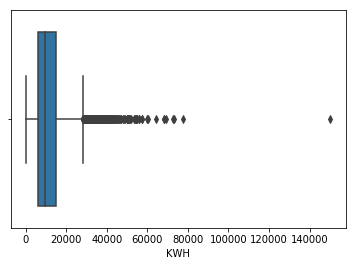

In [24]:
sns.boxplot(x=data_df['KWH'])
plt.show()

In [25]:
data_df['KWH'].describe()

count     12083.000000
mean      11288.159398
std        7641.190845
min          17.000000
25%        5837.000000
50%        9623.000000
75%       14765.000000
max      150254.000000
Name: KWH, dtype: float64

<b>As can be seen from the boxplot above, one datapoint is an outlier</b>

In [26]:
## Clearly, we have outliers in output variable distribution.Get rid of it
data_df = data_df[data_df['KWH']<=80000]
print(data_df.shape)

(12082, 233)


### A.2.2 Checking distribution of dependent variable KWH 

In [27]:
import scipy.stats as st
import statsmodels.api as sm
plt.figure(1)
plt.title('Fitting Johnson SU distribution of DV')
sns.distplot(data_df['KWH'], kde=False, fit=st.johnsonsu) ## https://blogs.sas.com/content/iml/2020/01/27/johnson-su-distribution.html
plt.show()

In [28]:
plt.figure(2)
sm.qqplot(data_df['KWH'],line='s')
plt.show()

<Figure size 432x288 with 0 Axes>

* As can be seen from the PDF plot and QQ plot above, KWH is not Normal and is at best approximated by Johnson SU distribution even after removal of outlier. We will have to transform Dependent Variable KWH to normal using a transformation like Box-Cox transformation or others.... [https://towardsdatascience.com/is-normal-distribution-necessary-in-regression-how-to-track-and-fix-it-494105bc50dd] 
* <u>Though it is not necessary to have normally distributed DV for RandomForest model, we will still go ahead and transform it using Johnson SU transformation</u>
* List of transformations: http://www.biostathandbook.com/transformation.html

In [29]:
def johnson(y):
    gamma, eta, epsilon, lbda = stats.johnsonsu.fit(y)
    yt = gamma + eta*np.arcsinh((y-epsilon)/lbda)
    return yt, gamma, eta, epsilon, lbda

<Figure size 432x288 with 0 Axes>

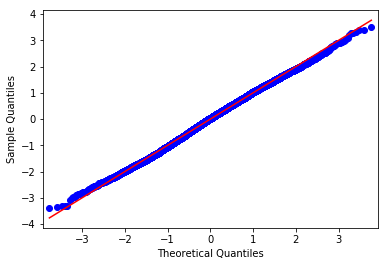

In [30]:
yt, g, et, ep, l = johnson(data_df['KWH'].values)
plt.figure(3)
sm.qqplot(yt,line='s')
plt.show()

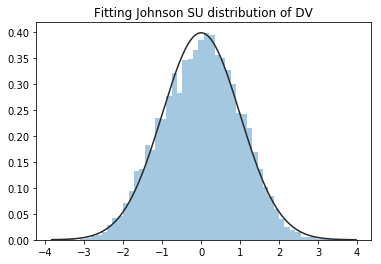

In [31]:
plt.figure(4)
plt.title('Fitting Johnson SU distribution of DV')
sns.distplot(yt, kde=False, fit=st.johnsonsu)
plt.show()

* Clearly, the distibution becomes normal as can be seen from PDF graph and QQ plot.
* Add KWH_normal as a new column to dataframe

In [32]:
data_df['KWH_normal'] = yt

## A.3. Check distribution of Independent variables

### A.3.1 Checking distribution for Independent numerical_continuous variables

* These are the variables in <b>numerical_continuous_variable_list</b> 
* Plot: Distplot
* Y axis is Prob density and not probability[https://stackoverflow.com/questions/51666784/what-is-y-axis-in-seaborn-distplot,https://towardsdatascience.com/histograms-and-density-plots-in-python-f6bda88f5ac0 ]

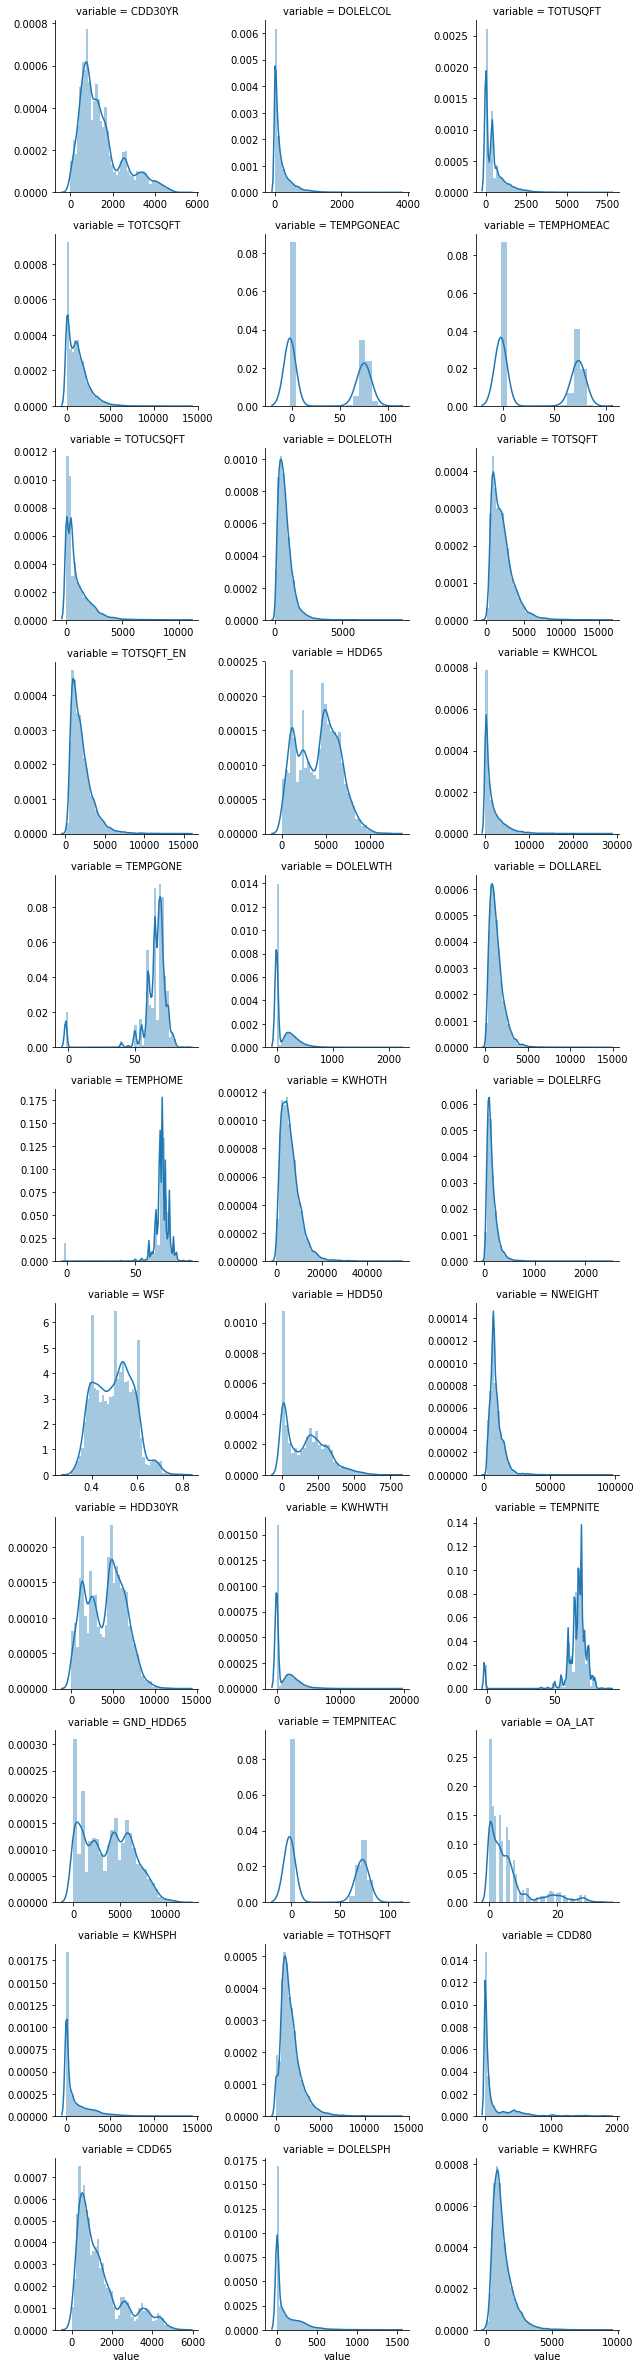

In [33]:
f = pd.melt(data_df, value_vars=numerical_continuous_variable_list)
g = sns.FacetGrid(f, col="variable", col_wrap=3, sharex=False, sharey=False)
g.map(sns.distplot, "value")

In [34]:
## Using Shapiro Wilk test to show that the numerical_continuous_variable_list are NOT NORMAL...
test_normality = lambda x: stats.shapiro(x.fillna(0))[1] < 0.01
normal = pd.DataFrame(data_df[numerical_continuous_variable_list])
normal = normal.apply(test_normality)
print(not normal.any())

False


* As can be seen from the graphs and results of Shapiro Wilk test, none of the continuous variables are normally distributed. 
* <u>Even though RandomForestRegressor does not need it, the above plots help us in identifying what kind of transformation is needed to convert them into normal form.</u>

### A.3.2 Checking distribution for Independent numerical_discrete  variables

* These variables are present in <b>numerical_discrete_variable_list</b>
* Plot: Count Plot

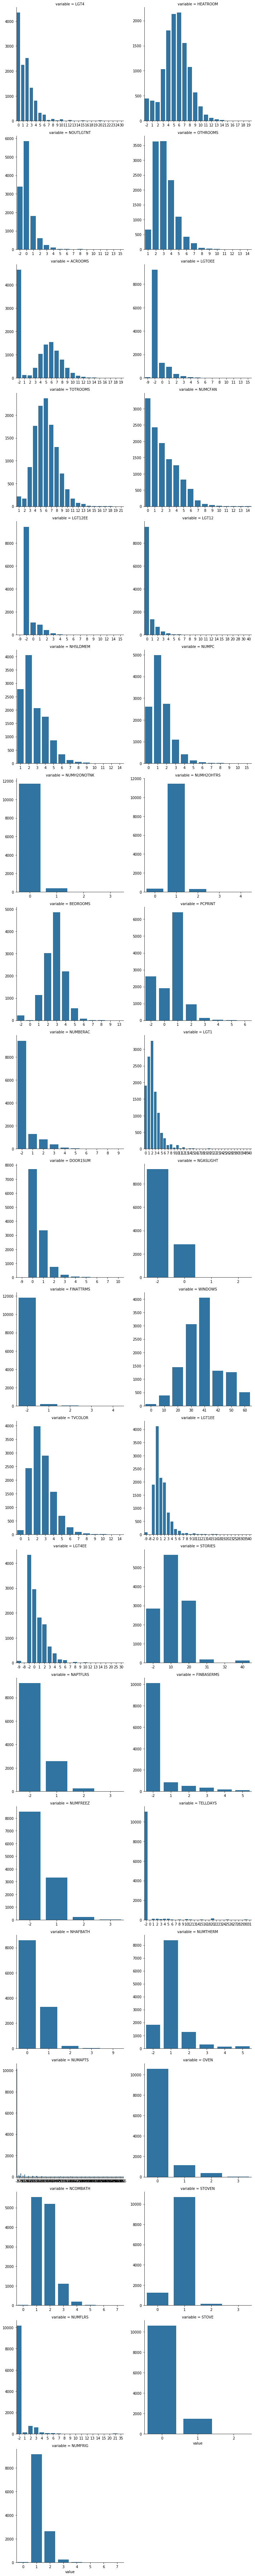

In [35]:
f_discrete = pd.melt(data_df, value_vars=numerical_discrete_variable_list)
g_discrete = sns.FacetGrid(f_discrete, col="variable", col_wrap=2, sharex=False, sharey=False, height=5)
g_discrete.map(sns.countplot, "value")

### A.3.3 Checking distribution for Independent categorical_binary  variables 

* Variables present in <b>categorical_binary_variable_list</b>
* Plot: BoxPlot
* Plotted wrt <b>KWH_normal</b>
* Perfom <b>2 sample T test</b> to understand whether the mean of KWH_normal for different levels of binary variable is statistically significant [https://www.statology.org/two-sample-t-test-python/, https://www.khanacademy.org/math/ap-statistics/two-sample-inference/two-sample-t-test-means/v/two-sample-t-test-for-difference-of-means, https://courses.lumenlearning.com/boundless-statistics/chapter/hypothesis-testing-two-samples/, https://www.technologynetworks.com/informatics/articles/paired-vs-unpaired-t-test-differences-assumptions-and-hypotheses-330826]

In [36]:
def boxplot(x, y, **kwargs):
    sns.boxplot(x=x, y=y)
    x=plt.xticks(rotation=90)

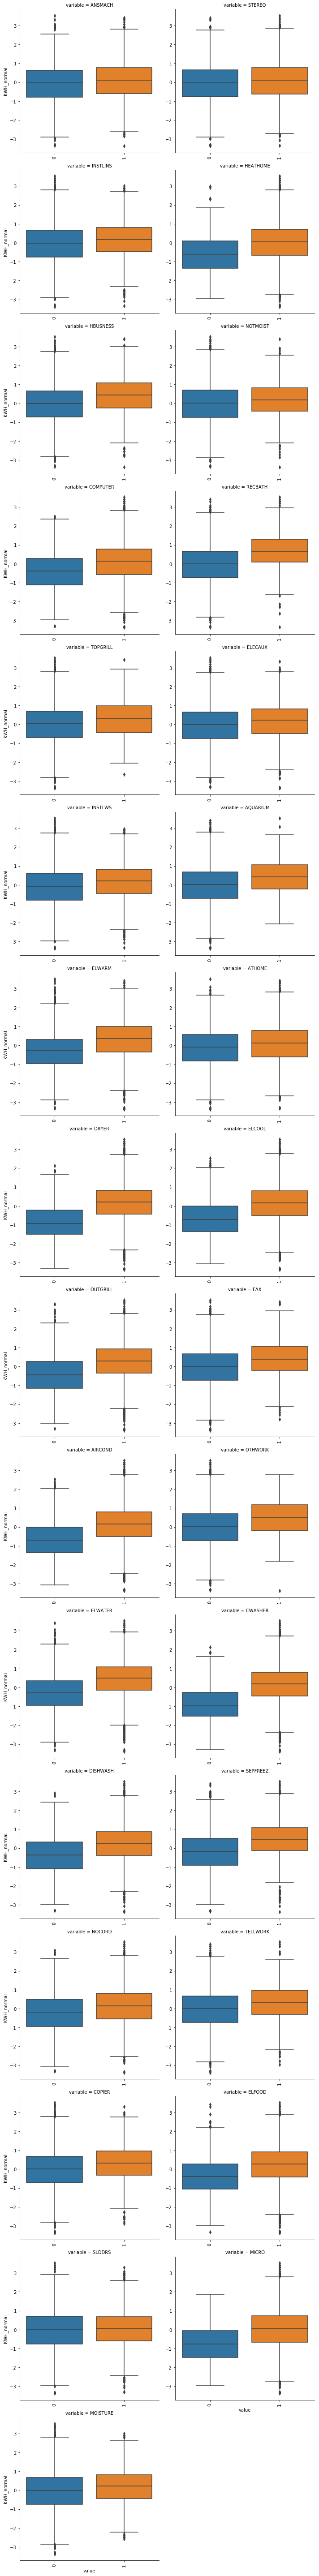

In [37]:
f_bin = pd.melt(data_df, id_vars=['KWH_normal'], value_vars=categorical_binary_variable_list)
g_bin = sns.FacetGrid(f_bin, col="variable",  col_wrap=2, sharex=False, sharey=False, size=5)
g_bin = g_bin.map(boxplot, "value", "KWH_normal")

In [38]:
def two_sample_t_test(frame, column_name_list, dv):
    t = pd.DataFrame()
    t['feature'] = column_name_list
    pvals = []
    for c in column_name_list:
        samples = []
        for cls in frame[c].unique():
            s = frame[frame[c] == cls][dv].values
            samples.append(s)
        pval = stats.ttest_ind(a=samples[0], b=samples[1], equal_var=False)[1]
        pvals.append(pval)
    t['pval'] = pvals
    return t.sort_values('pval')

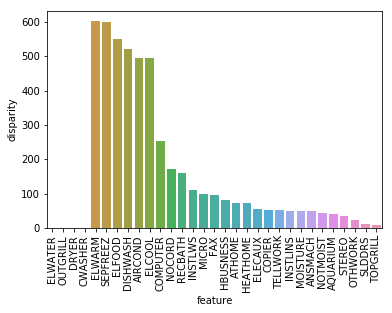

In [39]:
t_test_df = two_sample_t_test(data_df, categorical_binary_variable_list, 'KWH_normal')
t_test_df['disparity'] = np.log(1./t_test_df['pval'].values)
sns.barplot(data=t_test_df, x='feature', y='disparity')
x=plt.xticks(rotation=90)

In [40]:
t_test_df.head()

feature           pval   disparity
20   ELWATER   0.000000e+00         inf
16  OUTGRILL   0.000000e+00         inf
14     DRYER   0.000000e+00         inf
21   CWASHER   0.000000e+00         inf
12    ELWARM  1.305390e-262  603.010793

* Disparity = log(1/p-value) is considered as a proxy to measure how different groupp means are.
* Higher the disparity, higher the variation in KWH_normal dependent on levels of binary variables

In [41]:
# t_test_df.to_csv(Path(data_path)/'categorical_binary_t_test.csv')

### A.3.4 Checking distribution for Independent categorical_nominal  variables 

* Variables present in <b>categorical_nominal_variable_list</b>
* Plot: BoxPlot
* Plotted wrt <b>KWH_normal</b>
* Perfom <b>ANOVA F-test</b> to understand whether the mean of KWH_normal for different levels of nominal variable is statistically significant [https://blog.minitab.com/blog/adventures-in-statistics-2/understanding-analysis-of-variance-anova-and-the-f-test, https://statisticsbyjim.com/anova/f-tests-anova/]

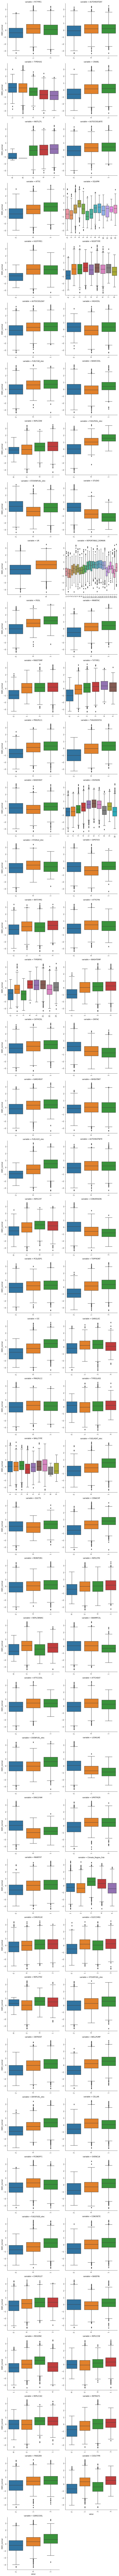

In [42]:
f_nominal = pd.melt(data_df, id_vars=['KWH_normal'], value_vars=categorical_nominal_variable_list)
g_nominal = sns.FacetGrid(f_nominal, col="variable",  col_wrap=2, sharex=False, sharey=False, size=5)
g_nominal = g_nominal.map(boxplot, "value", "KWH_normal")

In [43]:
def anova(frame, column_name_list, dv):
    anv = pd.DataFrame()
    anv['feature'] = column_name_list
    pvals = []
    for c in column_name_list:
        samples = []
        for cls in frame[c].unique():
            s = frame[frame[c] == cls][dv].values
            samples.append(s)
            
        pval = stats.f_oneway(*samples)[1]
        pvals.append(pval)
    anv['pval'] = pvals
    return anv.sort_values('pval')

In [44]:
a = anova(data_df, categorical_nominal_variable_list, 'KWH_normal')
a['disparity'] = np.log(1./a['pval'].values)
plt.figure(figsize=(25,8))
sns.barplot(data=a, x='feature', y='disparity')
x=plt.xticks(rotation=90)

* Disparity = log(1/p-value) is considered as a proxy to measure how different groupp means are.
* Higher the disparity, higher the variation in KWH_normal dependent on levels of nominal variables

In [45]:
a.head()

feature  pval  disparity
83           COOLTYPE   0.0        inf
27           DIVISION   0.0        inf
19  REPORTABLE_DOMAIN   0.0        inf
33           WASHTEMP   0.0        inf
43           TOPFRONT   0.0        inf

In [46]:
#a.to_csv(Path(data_path)/'categorical_nominal_f_test.csv')

### A.3.5 Checking distribution for Independent categorical_ordinal  variables 

* Variables present in <b>categorical_ordinal_variable_list</b>
* Plot: BoxPlot
* Plotted wrt <b>KWH_normal</b>
* Perfom <b>ANOVA F-test</b> to understand whether the mean of KWH_normal for different levels of ordinal variable is statistically significant [https://blog.minitab.com/blog/adventures-in-statistics-2/understanding-analysis-of-variance-anova-and-the-f-test, https://statisticsbyjim.com/anova/f-tests-anova/]

In [47]:
f_ordinal = pd.melt(data_df, id_vars=['KWH_normal'], value_vars=categorical_ordinal_variable_list)
g_ordinal = sns.FacetGrid(f_ordinal, col="variable",  col_wrap=2, sharex=False, sharey=False, size=5)
g_ordinal = g_ordinal.map(boxplot, "value", "KWH_normal")

In [48]:
a_ordinal = anova(data_df, categorical_ordinal_variable_list, 'KWH_normal')
a_ordinal['disparity'] = np.log(1./a_ordinal['pval'].values)
plt.figure(figsize=(25,8))
sns.barplot(data=a_ordinal, x='feature', y='disparity')
x=plt.xticks(rotation=90)

* Disparity = log(1/p-value) is considered as a proxy to measure how different groupp means are.
* Higher the disparity, higher the variation in KWH_normal dependent on levels of ordinal variables

In [49]:
a_ordinal.head()

feature  pval  disparity
35  AGECDRYER   0.0        inf
41    DRYRUSE   0.0        inf
25   AGECWASH   0.0        inf
36   USECENAC   0.0        inf
5    AGECENAC   0.0        inf

* Based upon analysis of results obtained in Sections 3.3, 3.4, 3.5, I zeroed in on the list of categorical variables to be used for further analysis
* This list is present in <b>categorical_var_chosen.txt</b>

In [51]:
with open(data_path+'/'+categorical_var_chosen_file_name) as f:
    categorical_var_to_use_list = [line.rstrip() for line in f]

## A.4. Variable selection

* Spearman correlation coefficient is a good way to find the degree of correlation between variables.
* Independent variables that have high degree of correlation with Dependent variable are GOOD CANDIDATES of variables to be included in the model.
* Independent Variables that have high degree of correlation amogst themselves can lead to <b>Multicollinearity</b> [https://statisticsbyjim.com/regression/multicollinearity-in-regression-analysis/, https://statisticsbyjim.com/glossary/correlation/]

### A.4.1 Finding spearman correlation coefficient between numerical variables & output variable KWH_normal

In [52]:
def spearman(frame, features, mean_var_name):
    spr = pd.DataFrame()
    spr['feature'] = features
    corr_list = []
    for f in features:
        corr_list.append(frame[f].corr(frame[mean_var_name], 'spearman'))
    spr['spearman'] = corr_list#[frame[f].corr(frame[mean_var_name], 'spearman') for f in features]
    spr = spr.sort_values('spearman')
    return spr

* Numerical variables means <b>numerical_continuous_variable_list</b>+<b>numerical_discrete_variable_list</b>

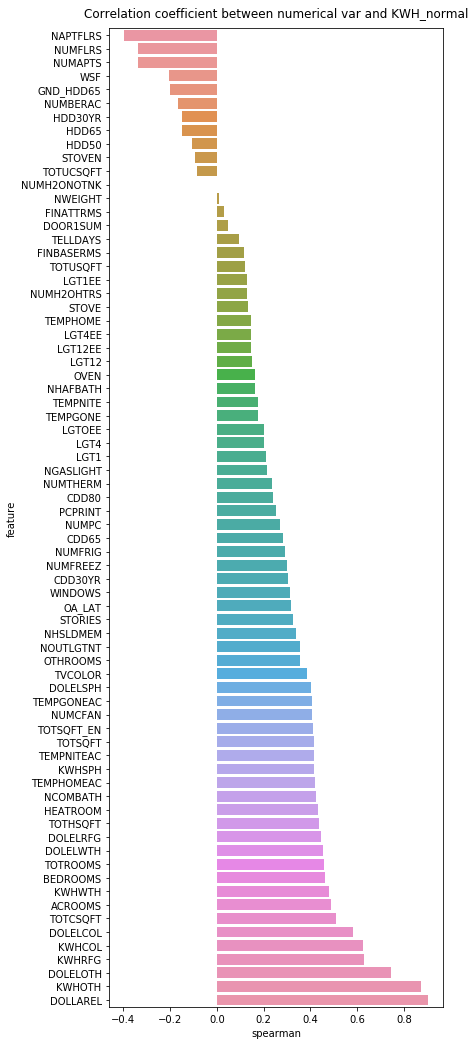

In [53]:
features_numerical = numerical_continuous_variable_list+numerical_discrete_variable_list#+ categorical_encoded
numerical_spr_df = spearman(data_df, features_numerical, 'KWH_normal')
plt.figure(figsize=(6, 0.25*len(features_numerical)))
numerical_barplot = sns.barplot(data=numerical_spr_df, y='feature', x='spearman', orient='h')
numerical_barplot.set_title('Correlation coefficient between numerical var and KWH_normal', fontdict={'fontsize':12}, pad=12);

In [54]:
high_correlation_with_output_numerical_var = numerical_spr_df[(numerical_spr_df['spearman']>=0.2) | (numerical_spr_df['spearman']<=-0.2)]['feature'].tolist()

* <b>high_correlation_with_output_numerical_var</b> contains numerical variables with spearman correlation greater than 0.2 or less than -0.2 to be used as input to model

### A.4.2 Finding spearman correlation coefficient between categorical variables & output variable KWH_normal

* Categorical variable means variables in <b>categorical_var_to_use_list</b>
* Need to encode these variables so that are ranked by mean of KWH_normal value per category. Basically we are creating ranks in the data by this way

#### A.4.2.1 Encode categorical variables using mean of KWH_normal

In [55]:
def encode(frame, feature, mean_var_name):
    ordering = pd.DataFrame()
    ordering['val'] = frame[feature].unique()
    ordering.index = ordering.val
    ordering['spmean'] = frame[[feature, mean_var_name]].groupby(feature).mean()[mean_var_name]
    ordering = ordering.sort_values('spmean')
    ordering['ordering'] = range(1, ordering.shape[0]+1)
    ordering = ordering['ordering'].to_dict()
    
    for cat, o in ordering.items():
        frame.loc[frame[feature] == cat, feature+'_E'] = o

In [56]:
categorical_encoded = []
for q in categorical_var_to_use_list:  
    encode(data_df, q, 'KWH_normal')
    categorical_encoded.append(q+'_E')

In [57]:
data_df.head()

REGIONC  DIVISION  REPORTABLE_DOMAIN  TYPEHUQ   NWEIGHT  HDD65  CDD65  \
0        2         4                 12        2   2471.68   4742   1080   
1        4        10                 26        2   8599.17   2662    199   
2        1         1                  1        5   8969.92   6233    505   
3        2         3                  7        2  18003.64   6034    672   
4        1         1                  1        3   5999.61   5388    702   

   HDD30YR  CDD30YR  Climate_Region_Pub  ... AGEWS_E  BASEHT2_E  AGEINS_E  \
0     4953     1271                   4  ...     1.0        3.0       5.0   
1     2688      143                   5  ...     1.0        1.0       2.0   
2     5741      829                   1  ...     1.0        1.0       2.0   
3     5781      868                   1  ...     1.0        1.0       2.0   
4     5313      797                   1  ...     6.0        1.0       2.0   

   ADQINSUL_E  WHEATAGE_E  SIZEOFDETACH_E  WHEATSIZ_E  AGERFRI1_E  ATTCCL2_E  \
0         4.0         6.0             2.0         4.0         6.0        1.0   
1         2.0         5.0             2.0         4.0         4.0        1.0   
2         3.0         2.0             2.0         4.0         6.0        1.0   
3         4.0         7.0             2.0         4.0         7.0        1.0   
4         3.0         6.0             1.0         3.0         7.0        1.0   

   ATTCHT2_E  
0        1.0  
1        1.0  
2        1.0  
3        1.0  
4        1.0  

[5 rows x 373 columns]

#### A.4.2.2 Finding spearman correlation coefficient between encoded categorical variables & output variable KWH_normal

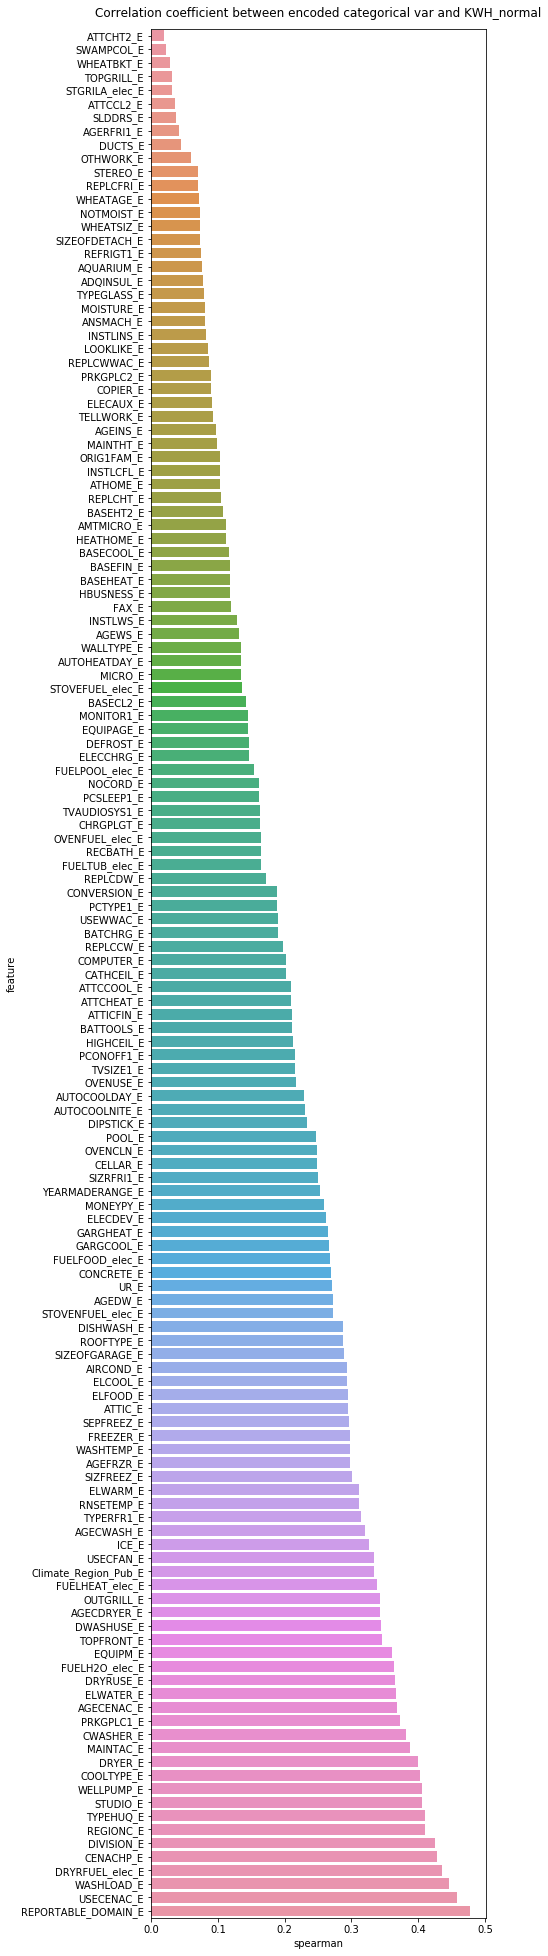

In [58]:
features_categorical = categorical_encoded
categorical_spr_df = spearman(data_df, features_categorical, 'KWH_normal')
plt.figure(figsize=(6, 0.25*len(features_categorical)))
categorical_barplot = sns.barplot(data=categorical_spr_df, y='feature', x='spearman', orient='h')
categorical_barplot.set_title('Correlation coefficient between encoded categorical var and KWH_normal', fontdict={'fontsize':12}, pad=12);

In [59]:
high_correlation_with_output_categorical_var = categorical_spr_df[(categorical_spr_df['spearman']>=0.2)]['feature'].tolist()

* <b>high_correlation_with_output_categorical_var</b> contains categorical variables with spearman correlation greater than 0.2 or less than -0.2 to be used as input to model

### A.4.3 Correlation matrices between independent numerical variables

* Use variables in <b>high_correlation_with_output_numerical_var</b>

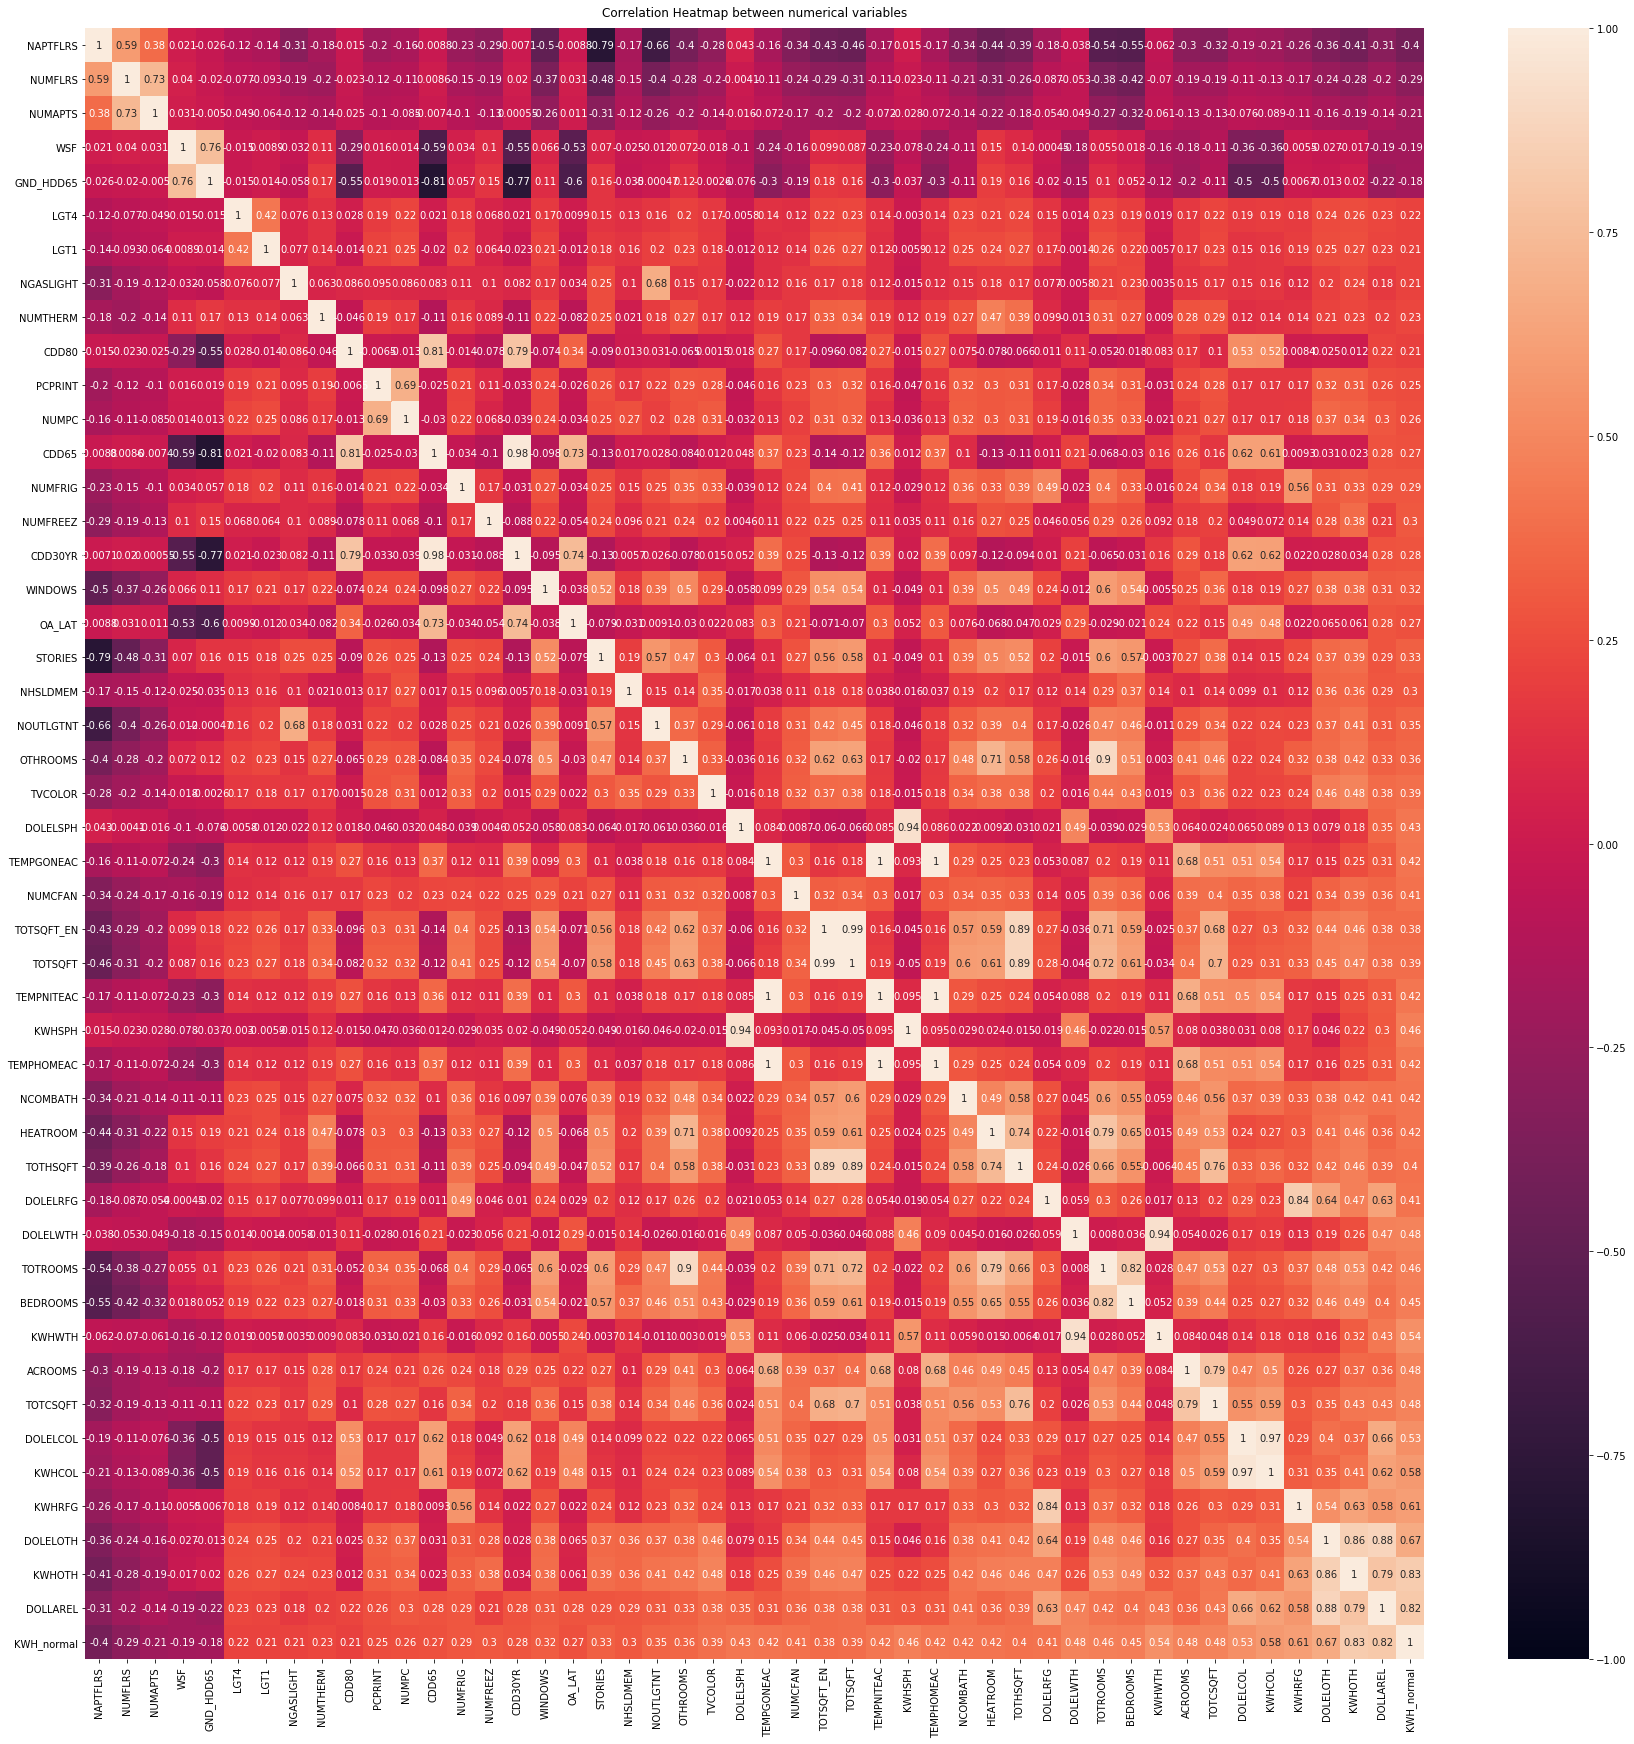

In [60]:
plt.figure(figsize=(30,30))
numerical_corr = data_df[high_correlation_with_output_numerical_var+['KWH_normal']].corr()
numerical_hmap = sns.heatmap(numerical_corr, vmin=-1, vmax=1, annot=True)
numerical_hmap.set_title('Correlation Heatmap between numerical variables', fontdict={'fontsize':12}, pad=12);

### A.4.4 Correlation matrices between independent categorical variables

* Variables used are <b>high_correlation_with_output_categorical_var</b>

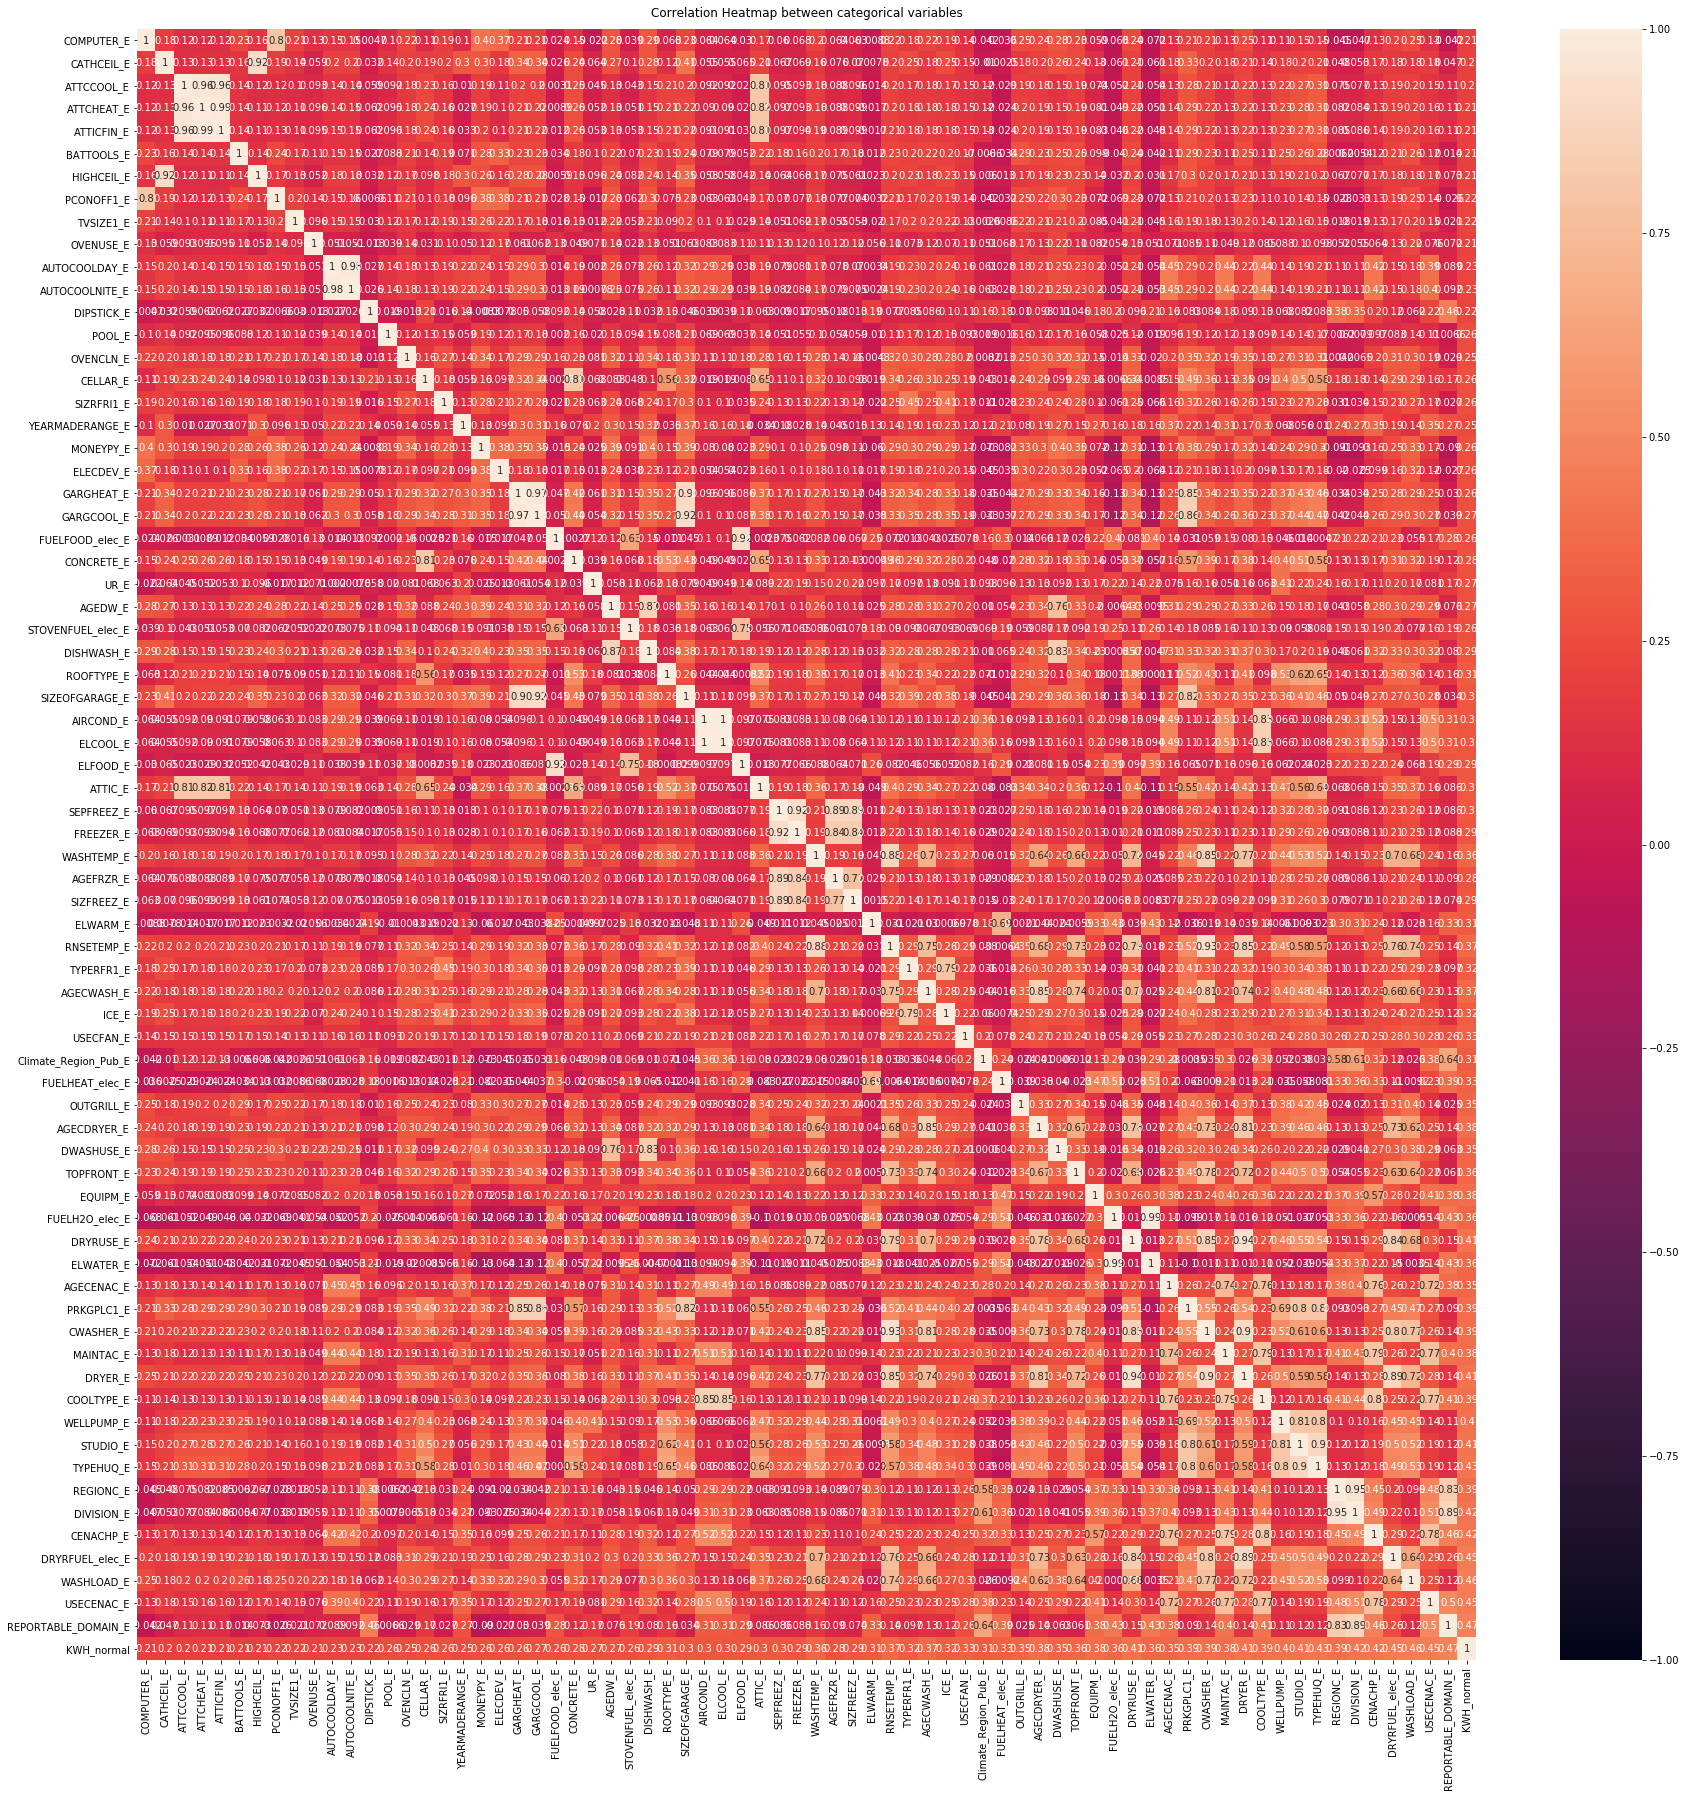

In [61]:
plt.figure(figsize=(30,30))
categorical_corr = data_df[high_correlation_with_output_categorical_var+['KWH_normal']].corr()
categorical_hmap = sns.heatmap(categorical_corr, vmin=-1, vmax=1, annot=True)
categorical_hmap.set_title('Correlation Heatmap between categorical variables', fontdict={'fontsize':12}, pad=12);

* Generally the Independent variables that have very high collinearity should be removed from the model
* RandomForestRegressor is not particularly impacted by Multicollinearity but models like Linear Regression are heavily impacted by it.

# B. MODEL TRAINING

## B.1 Data preparation for training.
* Involves performing appropriate encodings for categorical variables
* One hot encoding : https://hackernoon.com/what-is-one-hot-encoding-why-and-when-do-you-have-to-use-it-e3c6186d008f
* Ordinal encoding: https://kiwidamien.github.io/encoding-categorical-variables.html

In [63]:
categorical_var_model_training = [v[:v.rfind('_E')] if v.endswith('_E') else v for v in high_correlation_with_output_categorical_var]

In [64]:
## Separate Categorical variables into binary, nominal and ordinal
cat_var_training_dict = defaultdict(list)
for v in categorical_var_model_training:
    if v in categorical_binary_variable_list:
        cat_var_training_dict['binary'].append(v)
    elif v in categorical_nominal_variable_list:
        cat_var_training_dict['nominal'].append(v)
    elif v in categorical_ordinal_variable_list:
        cat_var_training_dict['ordinal'].append(v)
    else:
        print("ERREO1")

In [65]:
binary_var_data_df = data_df[cat_var_training_dict['binary']] ## All these variables will be as such
binary_var_data_df.reset_index(inplace=True, drop=True)

In [66]:
nominal_var_data_df = pd.get_dummies(data_df[cat_var_training_dict['nominal']].astype(str))
nominal_var_data_df.reset_index(inplace=True, drop=True)

In [67]:
from sklearn.preprocessing import OrdinalEncoder

battools = list(map(lambda x:str(x), [0,1,2,3]))
tvsize = list(map(lambda x:str(x), [-2,1,2,3]))
ovenuse = list(map(lambda x:str(x), [-2,0,1,2,3,4,5,6]))
sizefri = list(map(lambda x:str(x), [-2,1,2,3,4,5]))
yearmaderange = list(map(lambda x:str(x), [1,2,3,4,5,6,7,8]))
money = list(map(lambda x:str(x), [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24]))
elecdev = list(map(lambda x:str(x), [0,1,2,3]))
agedw = list(map(lambda x:str(x), [-2,1,2,3,41,42,5]))
sizeofgarage = list(map(lambda x:str(x), [-2,1,2,3]))
agefreezer = list(map(lambda x:str(x), [-2,1,2,3,41,42,5]))
sizefreezer = list(map(lambda x:str(x), [-2,1,2,3,4]))
ageclothwasher = list(map(lambda x:str(x), [-2,1,2,3,41,42,5]))
usefan = list(map(lambda x:str(x), [-2,4,1,2,3]))
agedryer = list(map(lambda x:str(x), [-2,1,2,3,41,42,5]))
dwashuse = list(map(lambda x:str(x), [-2,11,12,13,20,30]))
dryruse = list(map(lambda x:str(x), [-2,3,2,1]))
ageac = list(map(lambda x:str(x), [-2,1,2,3,41,42,5]))
washload = list(map(lambda x:str(x), [-2,1,2,3,4,5]))
useac = list(map(lambda x:str(x),[-2,1,2,3] ))

encoder = OrdinalEncoder(categories=[battools, tvsize,ovenuse, sizefri, yearmaderange, money, elecdev, agedw, sizeofgarage, agefreezer, sizefreezer, ageclothwasher,usefan, agedryer, dwashuse, dryruse, ageac, washload, useac ])
# transform data
ordinal_var_data_array = encoder.fit_transform(data_df[cat_var_training_dict['ordinal']].astype(str))
#print(result)

In [68]:
ordinal_var_data_df = pd.DataFrame(ordinal_var_data_array)
ordinal_var_data_df.columns = cat_var_training_dict['ordinal']
ordinal_var_data_df.reset_index(inplace=True, drop=True)

In [69]:
numerical_var_data_df = data_df[high_correlation_with_output_numerical_var]

In [70]:
numerical_var_data_df = numerical_var_data_df.apply(lambda x : x.map(lambda v : 0 if v == -2 else v))
numerical_var_data_df.reset_index(inplace=True, drop=True)

In [71]:
## Combine all differnet dataframes to form one combined dataframe.
combined_model_df = pd.concat([numerical_var_data_df, binary_var_data_df, nominal_var_data_df,ordinal_var_data_df], axis=1)
combined_model_df.reset_index(inplace=True, drop=True)

In [72]:
#combined_model_df.to_csv(Path(data_path)/'X_combined_model_data_df.csv', index=False)
#data_df['KWH'].to_csv(Path(data_path)/'Y_combined_model_data_df.csv', index=False)

## B.2 Split the dataset into train and test set

In [76]:
X_combined_model_data_df = pd.read_csv(Path(data_path)/'X_combined_model_data_df.csv')
Y_combined_model_data_df = pd.read_csv(Path(data_path)/'Y_combined_model_data_df.csv')

In [77]:
print(X_combined_model_data_df.shape)

(12082, 259)


In [78]:
labels = np.array(Y_combined_model_data_df['KWH'])

feature_list = list(X_combined_model_data_df.columns)
features = np.array(X_combined_model_data_df)

In [79]:
from sklearn.model_selection import train_test_split
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.25,random_state = 42)

In [80]:
print("Shape of Training set is {s}".format(s=train_features.shape))
print("Shape of Testing set is {s}".format(s=test_features.shape))

Shape of Training set is (9061, 259)
Shape of Testing set is (3021, 259)


## B.3 Create Baseline model i.e. the model that returns average value at all time.

In [81]:
baseline_preds = [np.mean(test_labels)]*len(test_labels)

baseline_errors = abs(baseline_preds - test_labels)
print('Average baseline error: ', round(np.mean(baseline_errors), 2), 'degrees.')

Average baseline error:  5609.51 degrees.


* The model we train should aim to beat this

## B.3 Choose the model, loss function and evaluation metric to use
* I am using RandomForestRegressor to try and predict output variable KWH because 
     * No need to do variable transformations.
     * Automatically handles all types of variables.
     * No requirement of variables being distributed normally
     * Generally high performance owing to Bagging of output from constituent trees.
     * Performs some level of variable selection automatically.
* Loss function : Mean Squared Error (MSE) [https://heartbeat.fritz.ai/5-regression-loss-functions-all-machine-learners-should-know-4fb140e9d4b0]
* Metric: mean absolute percentage error (MAPE) [https://medium.com/towards-artificial-intelligence/evaluation-metrics-for-regression-problems-fff2ac8e3f43]

In [82]:
from sklearn.ensemble import RandomForestRegressor

In [83]:
# Instantiate model 
rf = RandomForestRegressor(n_estimators= 100, random_state=42, criterion='mse') #, criterion='mae'
rf.fit(train_features, train_labels);

In [84]:
# Use the forest's predict method on the test data
predictions = rf.predict(test_features)

# Calculate the absolute errors
errors = abs(predictions - test_labels)

# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

Mean Absolute Error: 548.62 degrees.


In [85]:
# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / test_labels)

# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

Accuracy: 94.75 %.


## B.3 Variable importance

In [ ]:
importances = list(rf.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

# Future work:
1. Use Cross Validation to choose the best set of hyperparameters for RandomForestModel and to check for overfitting.
2. Calculating prediction intervals for RandomForestRegressor: https://blog.datadive.net/prediction-intervals-for-random-forests/
3. Try multiple other models and compare the performace.